<a href="https://colab.research.google.com/github/arimicrodata/Data-Scientis-mastery/blob/main/Observasi%20Serviks%20Wanita%20(kanker)/Test_Prakanker_Serviks_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

👆 Langsung Buka Colab Agar View Responsive

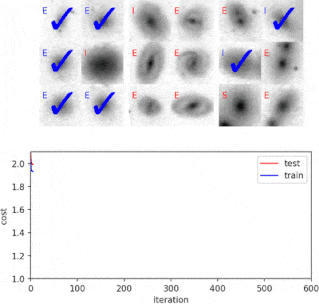

# **Observasi Analisa Kangker Serviks (Wanita)**

**`#kmenkes`**

In [ ]:
# import library
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils

os.environ["CUDA_VISIBLE_DEVICES"] ="1"

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
# Pengujian versi 8 50:30:20
# Unrar file via drive google
!unrar x -Y "/content/drive/MyDrive/pengujian_file/80-15-5_augmentasi_v2.rar" "/content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/pengujian_file/80-15-5_augmentasi_v2.rar

Creating    /content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/train  OK
Creating    /content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/train/abnormal  OK
Extracting  /content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/train/abnormal/flip0resized0_after10XX_abnormal.jpg       0%  OK 
Extracting  /content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/train/abnormal/flip0resized0_after10_abnormal.jpg       0%  OK 
Extracting  /content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/train/abnormal/flip0resized0_after11_abnormal.jpg       0%  OK 
Extracting  /content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/train/abnormal/flip0resized0_after12XX_abnormal.jpg       0%  OK 
Extractin

In [ ]:
# folder path file
train_abnormal_path = r"/content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/train/abnormal//"
train_normal_path = r"/content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/train/normal//"
test_abnormal_path = r"/content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/test/abnormal//"
test_normal_path = r"/content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/test/normal//"
valid_abnormal_path = r"/content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/valid/abnormal//"
valid_normal_path = r"/content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5/valid/normal//"

In [ ]:
test_normal_path_list = os.listdir(test_normal_path)
test_abnormal_path_list = os.listdir(test_abnormal_path)
train_normal_path_list = os.listdir(train_normal_path)
train_abnormal_path_list = os.listdir(train_abnormal_path)
valid_normal_path_list = os.listdir(valid_normal_path)
valid_abnormal_path_list = os.listdir(valid_abnormal_path)

In [ ]:
# show length folder
print(len(test_normal_path_list))
print(len(test_abnormal_path_list))
print(len(train_normal_path_list))
print(len(train_abnormal_path_list))
print(len(valid_normal_path_list))
print(len(valid_abnormal_path_list))

56
84
1036
1204
224
196


In [ ]:
# folder utama train valid test
file_dir_meta = r"/content/drive/MyDrive/data_prakanker_serviks/versi_2/mobileNetV2/80-15-5//"

In [ ]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder(file_dir_meta)
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=2800,
    splits={
        'test': 140,
        'train': 2240,
        'valid': 420,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



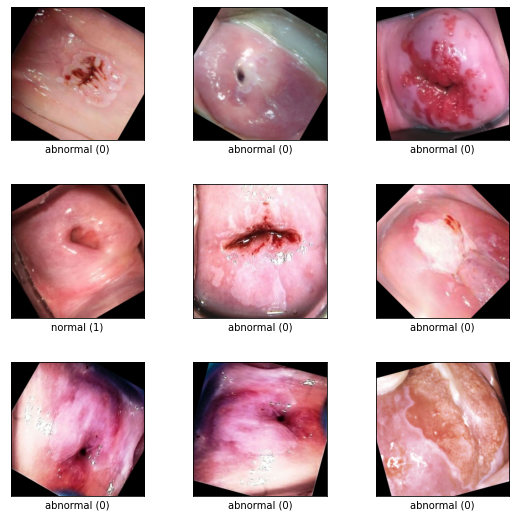

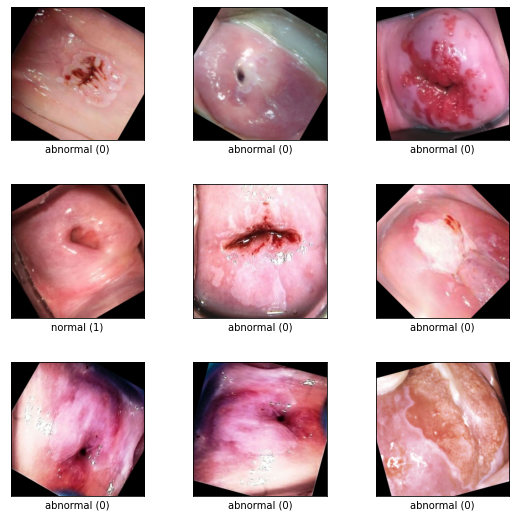

In [ ]:
tfds.show_examples(raw_train, builder.info)

In [ ]:
IMG_SIZE = 224 # All images will be resized to 224x224

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 30
validation_steps=50

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

14/50 [=======>......................] - ETA: 48s - loss: 0.8701 - accuracy: 0.4762WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50 batches). You may need to use the repeat() function when building your dataset.


50/50 [==============================] - 21s 372ms/step - loss: 0.8701 - accuracy: 0.4762


In [ ]:
dir_checkpoint = r"/content/drive/MyDrive/data_prakanker_serviks/versi_2/model/model_MobilleNet_class_v5.h5"
checkpoint = ModelCheckpoint(dir_checkpoint, #ini jangan lupa diganti
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

In [ ]:
dir_checkpoint = r"/content/drive/MyDrive/data_prakanker_serviks/versi_2/model/model_MobilleNet_class_v8.h5"
checkpoint = ModelCheckpoint(dir_checkpoint,
                             save_best_only=True)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.48


In [ ]:
# %%time
import time
start_time = time.time()
history_satu = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    callbacks=[checkpoint])
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/30
70/70 [==============================] - 75s 1s/step - loss: 0.0078 - accuracy: 0.9982 - val_loss: 0.0288 - val_accuracy: 0.9905
Epoch 2/30
70/70 [==============================] - 74s 1s/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.0289 - val_accuracy: 0.9905
Epoch 3/30
70/70 [==============================] - 73s 1s/step - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.0290 - val_accuracy: 0.9905
Epoch 4/30
70/70 [==============================] - 77s 1s/step - loss: 0.0070 - accuracy: 0.9987 - val_loss: 0.0291 - val_accuracy: 0.9905
Epoch 5/30
70/70 [==============================] - 74s 1s/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0293 - val_accuracy: 0.9905
Epoch 6/30
70/70 [==============================] - 75s 1s/step - loss: 0.0068 - accuracy: 0.9987 - val_loss: 0.0294 - val_accuracy: 0.9905
Epoch 7/30
70/70 [==============================] - 74s 1s/step - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.0296 - val_accuracy: 0.9905
Epoch 8/30
70/70 [==

In [ ]:
print('Train accuracy & loss:', model.evaluate(train_batches))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_batches))
print('\n')
print('Valid accuracy & loss:', model.evaluate(validation_batches))

70/70 [==============================] - 72s 966ms/step - loss: 0.0052 - accuracy: 0.9991
Train accuracy & loss: [0.005168462637811899, 0.9991071224212646]


140/140 [==============================] - 6s 40ms/step - loss: 0.0130 - accuracy: 0.9929
Test accuracy & loss: [0.012973207049071789, 0.9928571581840515]


14/14 [==============================] - 11s 767ms/step - loss: 0.0302 - accuracy: 0.9881
Valid accuracy & loss: [0.03020758181810379, 0.988095223903656]


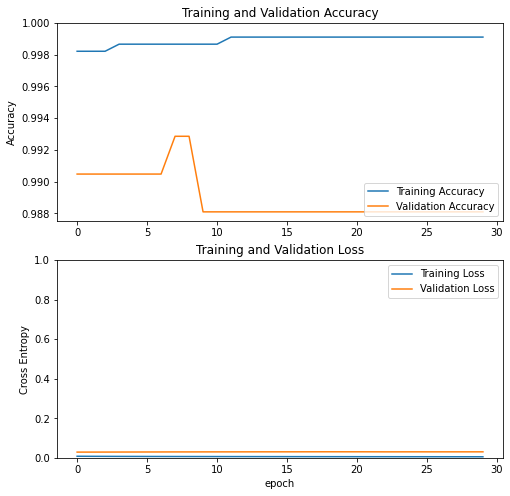

In [ ]:
acc_satu = history_satu.history['accuracy']
val_acc_satu = history_satu.history['val_accuracy']

loss_satu = history_satu.history['loss']
val_loss_satu = history_satu.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_satu, label='Training Accuracy')
plt.plot(val_acc_satu, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_satu, label='Training Loss')
plt.plot(val_loss_satu, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# %%time
import time
start_time = time.time()
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/30
70/70 [==============================] - 77s 1s/step - loss: 0.6357 - accuracy: 0.6250 - val_loss: 0.5646 - val_accuracy: 0.6286
Epoch 2/30
70/70 [==============================] - 80s 1s/step - loss: 0.5034 - accuracy: 0.7201 - val_loss: 0.4677 - val_accuracy: 0.7238
Epoch 3/30
70/70 [==============================] - 78s 1s/step - loss: 0.4129 - accuracy: 0.7906 - val_loss: 0.3993 - val_accuracy: 0.7714
Epoch 4/30
70/70 [==============================] - 74s 1s/step - loss: 0.3488 - accuracy: 0.8402 - val_loss: 0.3612 - val_accuracy: 0.7929
Epoch 5/30
70/70 [==============================] - 76s 1s/step - loss: 0.3046 - accuracy: 0.8705 - val_loss: 0.3360 - val_accuracy: 0.8095
Epoch 6/30
70/70 [==============================] - 75s 1s/step - loss: 0.2708 - accuracy: 0.8844 - val_loss: 0.2904 - val_accuracy: 0.8619
Epoch 7/30
70/70 [==============================] - 75s 1s/step - loss: 0.2444 - accuracy: 0.9071 - val_loss: 0.2790 - val_accuracy: 0.8595
Epoch 8/30
70/70 [==

In [ ]:
print('Train accuracy & loss:', model.evaluate(train_batches))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_batches))
print('\n')
print('Valid accuracy & loss:', model.evaluate(validation_batches))

70/70 [==============================] - 63s 860ms/step - loss: 0.0613 - accuracy: 0.9915
Train accuracy & loss: [0.061307888478040695, 0.9915178418159485]


5/5 [==============================] - 4s 652ms/step - loss: 0.0830 - accuracy: 0.9286
Test accuracy & loss: [0.08301170915365219, 0.9285714030265808]


14/14 [==============================] - 11s 744ms/step - loss: 0.1304 - accuracy: 0.9357
Valid accuracy & loss: [0.13035820424556732, 0.9357143044471741]


In [ ]:
# train = raw_train.map(format_example)
# validation = raw_valid.map(format_example)
# test = raw_test.map(format_example)
print('Train accuracy & loss:', model.evaluate(train))
print('\n')
print('Test accuracy & loss:', model.evaluate(test))
print('\n')
print('Valid accuracy & loss:', model.evaluate(validation))

ValueError: ignored

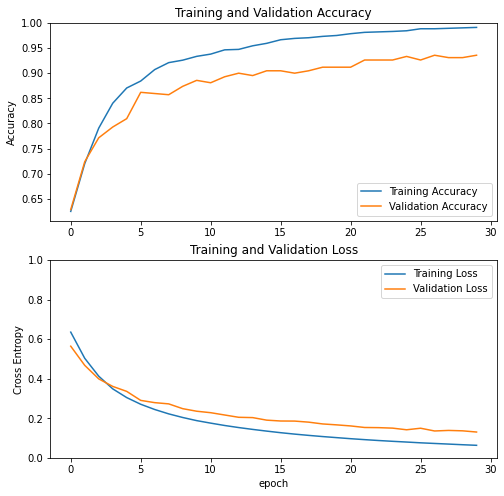

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

In [ ]:
import time
start_time = time.time()
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 30/80
70/70 [==============================] - 77s 1s/step - loss: 1.1534 - accuracy: 0.7683 - val_loss: 1.6496 - val_accuracy: 0.7071
Epoch 31/80
70/70 [==============================] - 74s 1s/step - loss: 1.0750 - accuracy: 0.7768 - val_loss: 1.5486 - val_accuracy: 0.7143
Epoch 32/80
70/70 [==============================] - 77s 1s/step - loss: 1.0007 - accuracy: 0.7884 - val_loss: 1.4517 - val_accuracy: 0.7238
Epoch 33/80
70/70 [==============================] - 73s 998ms/step - loss: 0.9283 - accuracy: 0.7978 - val_loss: 1.3576 - val_accuracy: 0.7286
Epoch 34/80
70/70 [==============================] - 73s 1s/step - loss: 0.8634 - accuracy: 0.8116 - val_loss: 1.2712 - val_accuracy: 0.7405
Epoch 35/80
70/70 [==============================] - 73s 1s/step - loss: 0.8000 - accuracy: 0.8219 - val_loss: 1.1863 - val_accuracy: 0.7452
Epoch 36/80
70/70 [==============================] - 73s 998ms/step - loss: 0.7380 - accuracy: 0.8326 - val_loss: 1.1033 - val_accuracy: 0.7476
Epoch 3

In [ ]:
print('Train accuracy & loss:', model.evaluate(train_batches))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_batches))
print('\n')
print('Valid accuracy & loss:', model.evaluate(validation_batches))

70/70 [==============================] - 68s 891ms/step - loss: 0.0080 - accuracy: 0.9978
Train accuracy & loss: [0.007976810447871685, 0.9977678656578064]


5/5 [==============================] - 4s 664ms/step - loss: 0.0079 - accuracy: 1.0000
Test accuracy & loss: [0.007882852107286453, 1.0]


14/14 [==============================] - 11s 758ms/step - loss: 0.0288 - accuracy: 0.9881
Valid accuracy & loss: [0.028779851272702217, 0.988095223903656]


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

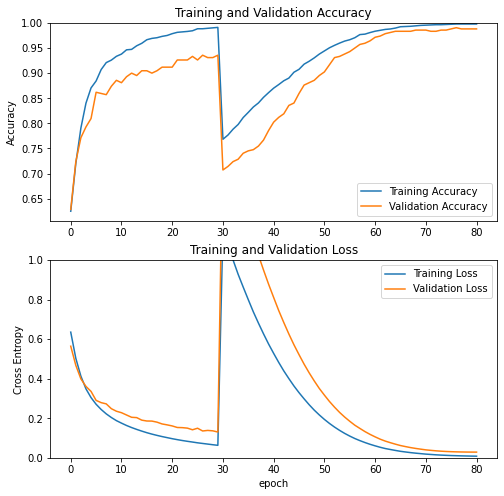

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
#define labels for testing
y_test = test_batches

#make prediction
yhat_test = np.argmax(model.predict(test_batches), axis=1)

#define labels for testing
y_valid = validation_batches

#make prediction
yhat_valid = np.argmax(model.predict(validation_batches), axis=1)

#define labels for testing
y_train = train_batches

#make prediction
yhat_train = np.argmax(model.predict(train_batches), axis=1)

In [ ]:
y_test = test_batches
y_test

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
y_uji_data = np.concatenate([y for x, y in y_test], axis=0)

In [ ]:
len(y_uji_data)

140

In [ ]:
start_time = time.time()
sum = 0
for i in range(100000000000000000000):
  sum += i
print(sum)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print(y_test)
print(yhat_test)
print('\n')
print(y_train)
print(yhat_train)
print('\n')
print(y_valid)
print(yhat_valid)
print('\n')

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
[0 0 0 ... 0 0 0]


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 

In [ ]:
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

ValueError: ignored

Text(0.5, 1.0, 'Abnormal')

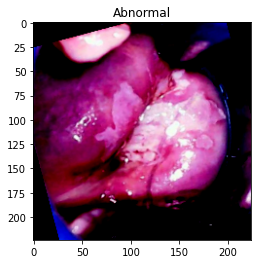

In [ ]:
test_batches = test.batch(1)
for image, label in test_batches.take(1):
  pass
plt.imshow(np.squeeze(image))
plt.title("Normal" if model.predict(image) > 0 else "Abnormal")

Text(0.5, 1.0, 'Abnormal')

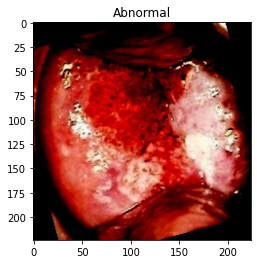

In [ ]:
test_batches = test.batch(1)
for image, label in test_batches.take(2):
  pass
plt.imshow(np.squeeze(image))
plt.title("Normal" if model.predict(image) > 0 else "Abnormal")


Text(0.5, 1.0, 'Abnormal')

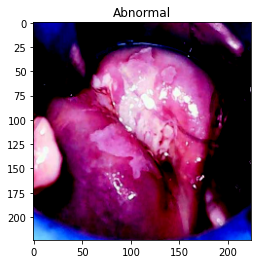

In [ ]:
test_batches = test.batch(1)
for image, label in test_batches.take(45):
  pass
plt.imshow(np.squeeze(image))
plt.title("Normal" if model.predict(image) > 0 else "Abnormal")

In [ ]:
type(image)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
type(label)

tensorflow.python.framework.ops.EagerTensor